# Classification Notebook
- Implement Logistic Regression, SVM, Random Forest, and Gradient Boosting
- Apply cross validation tuning for each
- Evaluates and compares results

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

RANDOM_STATE = 598

In [58]:
# map labels to actual names
label_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
             3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
             7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# load preprocessed data
with np.load('fashion_mnist_processed.npz') as data:
    X_train_pca = data['X_train_pca']
    X_test_pca = data['X_test_pca']
    
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    
    y_train = data['y_train']
    y_test = data['y_test']

print(f"PCA Train Shape: {X_train_pca.shape}")
print(f"Raw Train Shape: {X_train_scaled.shape}")

PCA Train Shape: (60000, 256)
Raw Train Shape: (60000, 784)


In [60]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n================ {model_name} ================")    
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3, target_names=list(label_map.values())))
    
    # confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(label_map.values()), 
                yticklabels=list(label_map.values()))
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return acc

# dictionary to store final results
results = {}

## Logistic Regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best LR Params: {'C': 0.1}

================ Logistic Regression ================
Test Accuracy: 0.8579

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top      0.799     0.818     0.808      1000
     Trouser      0.960     0.970     0.965      1000
    Pullover      0.774     0.765     0.770      1000
       Dress      0.863     0.887     0.875      1000
        Coat      0.788     0.808     0.798      1000
      Sandal      0.932     0.922     0.927      1000
       Shirt      0.659     0.603     0.630      1000
     Sneaker      0.902     0.916     0.909      1000
         Bag      0.949     0.946     0.947      1000
  Ankle boot      0.937     0.944     0.941      1000

    accuracy                          0.858     10000
   macro avg      0.856     0.858     0.857     10000
weighted avg      0.856     0.858     0.857     10000



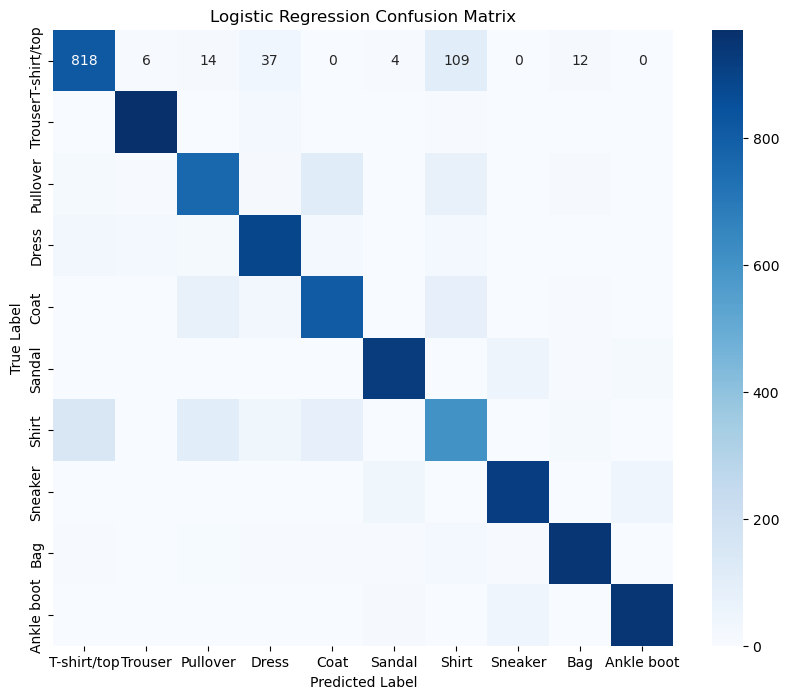

In [18]:
# using PCA features for faster convergence
log_reg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', # lbfgs, saga
    max_iter=10000, 
    random_state=RANDOM_STATE)

# grid search for regularization
param_grid_lr = {'C': [0.1, 1, 10]}
lr_cv = GridSearchCV(log_reg, param_grid_lr, cv=3, n_jobs=-1, verbose=1)

lr_cv.fit(X_train_pca, y_train)

print(f"Best LR Params: {lr_cv.best_params_}")
results['Logistic Regression'] = evaluate_model(lr_cv.best_estimator_, X_test_pca, y_test, "Logistic Regression")

## SVM

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................................C=1, gamma=scale; total time= 8.8min
[CV] END ..................................C=10, gamma=scale; total time= 8.0min
[CV] END ..................................C=10, gamma=scale; total time= 7.0min
[CV] END ....................................C=1, gamma=0.01; total time=26.0min
[CV] END ....................................C=1, gamma=0.01; total time=26.1min
[CV] END ....................................C=1, gamma=0.01; total time=26.3min
Best SVM Params: {'C': 10, 'gamma': 'scale'}

================ SVM ================
Test Accuracy: 0.9070

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top      0.832     0.879     0.855      1000
     Trouser      0.990     0.980     0.985      1000
    Pullover      0.856     0.839     0.847      1000
       Dress      0.914     0.919     0.916      1000
        Coat      0.850     0.878     0.864      1000

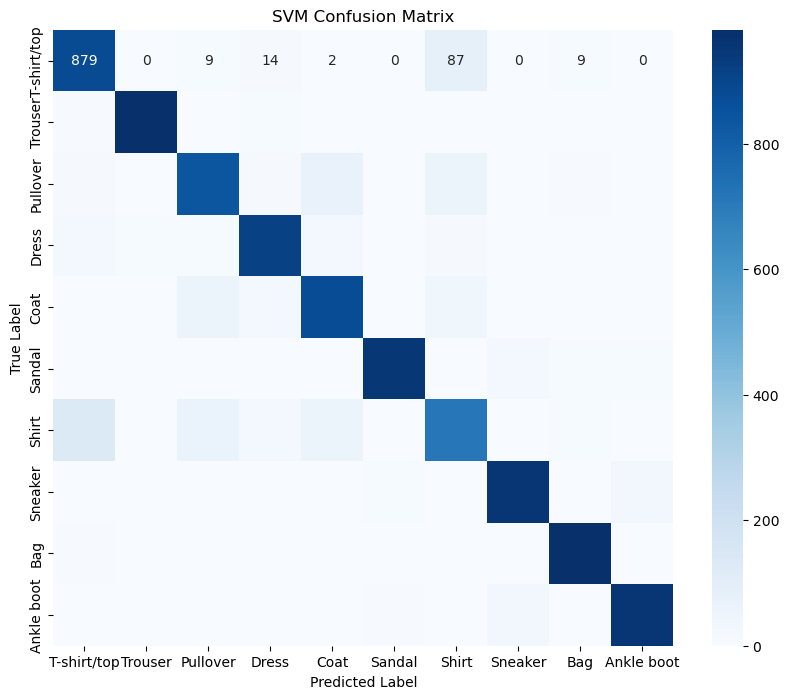

In [79]:
svm = SVC(kernel='rbf', random_state=RANDOM_STATE)

# reduced grid to save time
param_grid_svm = {
    'C': [1, 10], 
    'gamma': ['scale', 0.01]}

svm_cv = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
svm_cv.fit(X_train_pca, y_train)

print(f"Best SVM Params: {svm_cv.best_params_}")
results['SVM'] = evaluate_model(svm_cv.best_estimator_, X_test_pca, y_test, "SVM")

# Random Forest

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...................................C=1, gamma=scale; total time= 9.0min
[CV] END ...................................C=10, gamma=0.01; total time=22.4min
[CV] END ...................................C=1, gamma=scale; total time= 9.0min
[CV] END ...................................C=10, gamma=0.01; total time=22.4min
[CV] END ..................................C=10, gamma=scale; total time= 8.4min
[CV] END ...................................C=10, gamma=0.01; total time=22.8min
Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

================ Random Forest ================
Test Accuracy: 0.8844

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top      0.814     0.860     0.837      1000
     Trouser      0.991     0.971     0.981      1000
    Pullover      0.797     0.800     0.798      1000
       Dress      0.893     0.935     0.914      1000
       

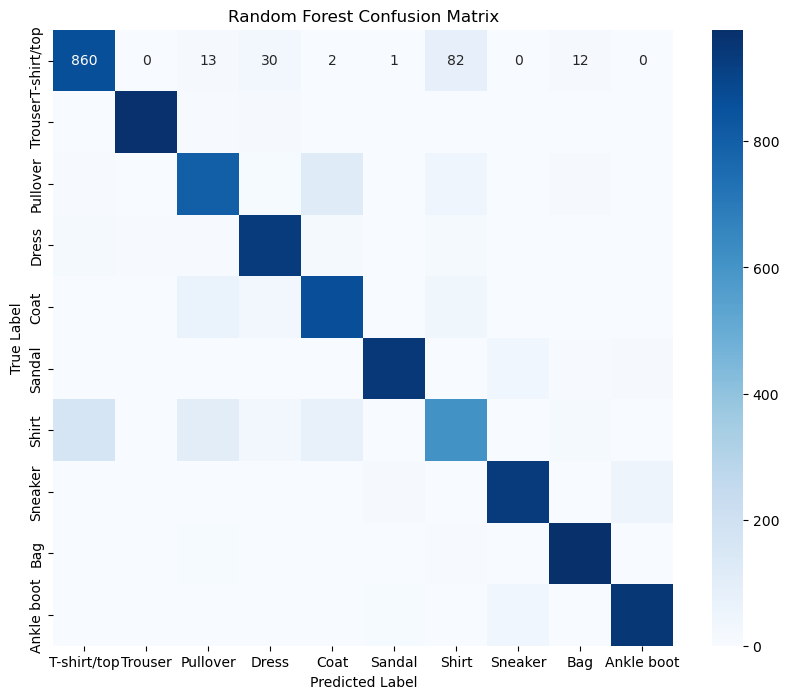

In [22]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, None],
    'min_samples_split': [2, 5]}

rf_cv = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, verbose=1)
rf_cv.fit(X_train_scaled, y_train)

print(f"Best RF Params: {rf_cv.best_params_}")
results['Random Forest'] = evaluate_model(rf_cv.best_estimator_, X_test_scaled, y_test, "Random Forest")

# Gradient Boosting

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Boosting Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}

================ Gradient Boosting ================
Test Accuracy: 0.9122

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top      0.857     0.887     0.872      1000
     Trouser      0.991     0.984     0.987      1000
    Pullover      0.857     0.840     0.848      1000
       Dress      0.915     0.930     0.923      1000
        Coat      0.850     0.882     0.866      1000
      Sandal      0.991     0.959     0.975      1000
       Shirt      0.787     0.735     0.760      1000
     Sneaker      0.945     0.960     0.952      1000
         Bag      0.970     0.978     0.974      1000
  Ankle boot      0.956     0.967     0.961      1000

    accuracy                          0.912     10000
   macro avg      0.912     0.912     0.912     10000
weighted avg      0.912     0.912     0.912     10000



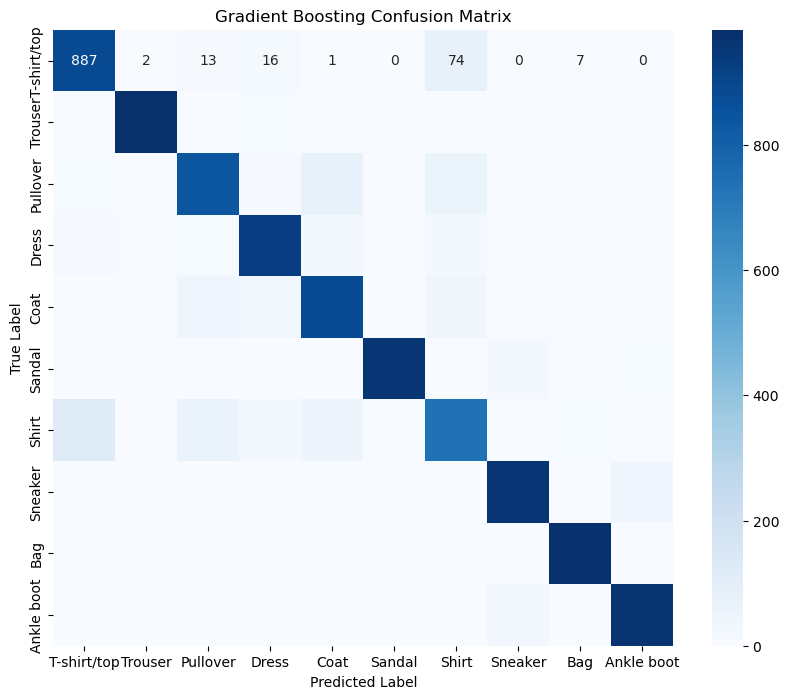

In [14]:
xgb = XGBClassifier(
    objective='multi:softmax', 
    num_class=10, 
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    tree_method='hist')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 6]}

xgb_cv = GridSearchCV(xgb, param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
xgb_cv.fit(X_train_scaled, y_train)

best_model_xgb = xgb_cv.best_estimator_
best_params_xgb = xgb_cv.best_params_
    

print(f"Best Boosting Params: {best_params_xgb}")
results['Gradient Boosting'] = evaluate_model(best_model_xgb, X_test_scaled, y_test, "Gradient Boosting")

# Results Comparison

                 Model  Test Accuracy
0    Gradient Boosting         0.9122
2                  SVM         0.9070
1        Random Forest         0.8844
3  Logistic Regression         0.8579


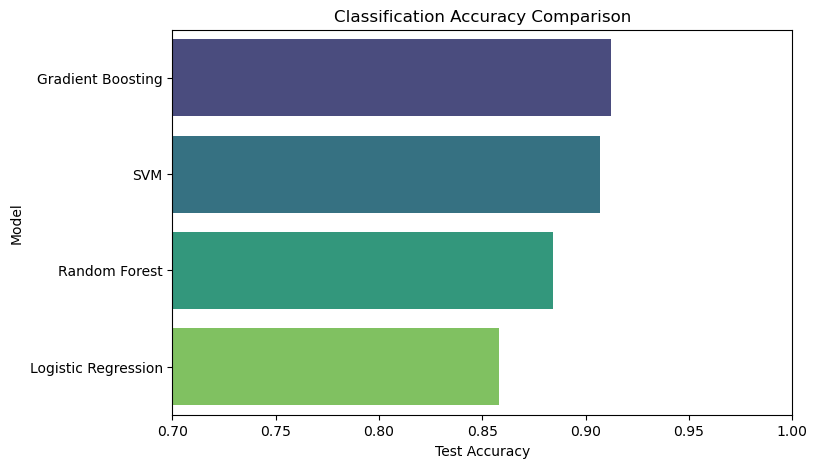

In [83]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test Accuracy'])
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='Test Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Classification Accuracy Comparison')
plt.xlim(0.7, 1.0)
plt.show()